In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('josh_final_dataset_7.14.csv')

In [3]:
del df['Unnamed: 0']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45604 entries, 0 to 45603
Data columns (total 30 columns):
Assets                                                                                                         39525 non-null float64
adsh                                                                                                           39525 non-null object
cik                                                                                                            45604 non-null int64
coreg                                                                                                          54 non-null object
ddate                                                                                                          39525 non-null float64
ein                                                                                                            37612 non-null float64
fy                                                                                            

## Dividing (Identifying) which companies are foreign and domestic

In [5]:
df['check1']=np.where(df.IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign.isnull(),0,1)
df['check2']=np.where(df.UndistributedEarningsOfForeignSubsidiaries.isnull(),0,1)
df['check3']=np.where(df.ForeignEarningsRepatriated.isnull(),0,1)

df['check']=df['check1']+df['check2']+df['check3']

In [6]:
del df['check1']
del df['check2']
del df['check3']

In [7]:
# Giving identifiers to companies as to whether each of them has foreign subsidiary(foreign operation) or not
df['Type of Firm'] = np.where(df.check==0,'Domestic','Foreign')

In [8]:
del df['check']

## Fixing years and number of companies for analysis constant

In [9]:
# Data only from fy 2013 to fy 2016
df_13_16 = df[(df.fy>=2013) & (df.fy<=2016)]

# Drop firms that have at least one missing Asset values from fy 2013-2016
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(pd.notnull(x['Assets'])))

# Drop firms that have at least one missing Liabilities values from fy 2013-2016
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(pd.notnull(x['Liabilities'])))

# Drop firms that have at least one missing Gross Profit(total income) values from fy 2013-2016
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(pd.notnull(x['GrossProfit'])))

df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(pd.notnull(x['ResearchAndDevelopmentExpense'])))

# Drop firms that have Asset value of 0 for at least one of the year
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(x['Assets']!=0.0))

In [10]:
# # Filter only the companies that have data for all fy years 2013 - 2016 (4 assets values per cik group)
# df_13_16 = df_13_16.groupby('cik').filter(lambda x: x['fy'].nunique()==4)

df_13_16_foreign = df_13_16.copy()[df_13_16.copy()['Type of Firm']=='Foreign']
df_13_16_domestic = df_13_16.copy()[df_13_16.copy()['Type of Firm']=='Domestic']

As we can see below, the problem is there are some firms that was domestic one year and was multinational for another year (inconsistent). We are going to drop those companies and exclude them from the analysis

In [11]:
print("Foreign:",df_13_16_foreign.groupby('fy').size(),"\n\n","Domestic:", df_13_16_domestic.groupby('fy').size())

Foreign: fy
2013.0    74
2014.0    68
2015.0    61
2016.0    71
dtype: int64 

 Domestic: fy
2013.0    72
2014.0    62
2015.0    43
2016.0    38
dtype: int64


In [12]:
# Dropping MNCs that have missing UFEs for all years
df_13_16_foreign = df_13_16_foreign.groupby('cik').filter(lambda x: all(pd.notnull(x['UndistributedEarningsOfForeignSubsidiaries'])))

In [13]:
df_13_16_foreign = df_13_16_foreign.groupby('cik').filter(lambda x: x['fy'].nunique()==4)
df_13_16_domestic = df_13_16_domestic.groupby('cik').filter(lambda x: x['fy'].nunique()==4)

# Now we have the same number of multinational firms and domestic firms throughout all years
print("Foreign:",df_13_16_foreign.groupby('fy').size(),"\n\n","Domestic:", df_13_16_domestic.groupby('fy').size())

Foreign: fy
2013.0    26
2014.0    26
2015.0    26
2016.0    26
dtype: int64 

 Domestic: fy
2013.0    16
2014.0    16
2015.0    16
2016.0    16
dtype: int64


In [14]:
# Make a new dataframe df_13_16 with the modified foreign and domestic firms data
df_13_16= df_13_16_foreign.append(df_13_16_domestic)

## Creating new variables [field]/Assets

In [15]:
# Creating new variable (total income / Assets)
df_13_16['Total_Income_scaled']=\
df_13_16['GrossProfit']/df_13_16['Assets']

In [16]:
# Creating new variable (Liabilties / Assets)
df_13_16['Liabilities_scaled']=\
df_13_16['Liabilities']/df_13_16['Assets']

In [17]:
# Creating new variable (R&D / Assets)
df_13_16['ResearchAndDevelopmentExpense_scaled']=\
df_13_16['ResearchAndDevelopmentExpense']/df_13_16['Assets']

## Giving each company industry classification

In [18]:
industry_count =\
pd.DataFrame([{'Mining and Construction':3551, 'Manufacturing':13162, 'Transportation, Communication, Electric, Gas':2889,
 'Wholesale, Retail':3116,'Financial, Insurance, Real Estate':9625, 'Services':6725,'Public Administration':103}],index=['count'])

# industry_count.to_csv('industry_count_breakdown.csv')

In [19]:
industry_count

,"Financial, Insurance, Real Estate",Manufacturing,Mining and Construction,Public Administration,Services,"Transportation, Communication, Electric, Gas","Wholesale, Retail"
count,9625,13162,3551,103,6725,2889,3116


In [20]:
# bins = pd.IntervalIndex.from_tuples([(1000, 1999), (2000, 3999),(4000,4999),(5000,5999),
#                                     (6000,6999),(7000,8999),(9000,9999)],closed='both')

df_13_16['industry']=\
pd.cut(df_13_16.sic.tolist(),[1000,1999,3999,4999,5999,6999,8999,9999],include_lowest=True,
             labels=['Mining and Construction','Manufacturing','Transportation, Communication, Electric, Gas',
               'Wholesale, Retail','Financial, Insurance, Real Estate','Services','Public Administration'])

## Comparison by Industry

- Industry1: 'Mining and Construction'
- Industry2: 'Manufacturing'
- Industry3: 'Transportation, Communication, Electric, Gas'
- Industry4: 'Wholesale, Retail'
- Industry5: 'Financial, Insurance, Real Estate'
- Industry6: 'Services'
- Industry7: 'Public Administration'

In [21]:
# Dividing data into 7 different industries

industry1 = df_13_16.copy()[df_13_16.copy().industry=='Mining and Construction']
industry2 = df_13_16.copy()[df_13_16.copy().industry=='Manufacturing']
industry3 = df_13_16.copy()[df_13_16.copy().industry=='Transportation, Communication, Electric, Gas']
industry4 = df_13_16.copy()[df_13_16.copy().industry=='Wholesale, Retail']
industry5 = df_13_16.copy()[df_13_16.copy().industry=='Financial, Insurance, Real Estate']
industry6 = df_13_16.copy()[df_13_16.copy().industry=='Services']
industry7 = df_13_16.copy()[df_13_16.copy().industry=='Public Administration']

In [22]:
industry2['Type of Firm'].value_counts()

Foreign     100
Domestic     56
Name: Type of Firm, dtype: int64

### Manufacturing

**Undistributed Foreign Earnings**

In [23]:
industry2['UndistributedEarningsOfForeignSubsidiaries_scaled']=\
industry2['UndistributedEarningsOfForeignSubsidiaries']/industry2['Assets']

Text(0.5,1,'Mean Undistributed Foreign Earnings normalized (Manufacturing)')

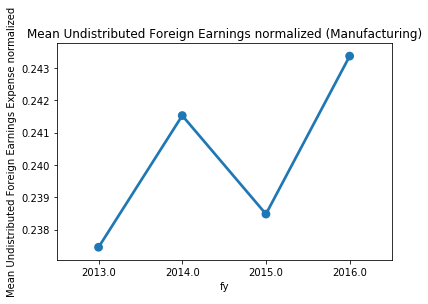

In [24]:
# Mean Normalized Undistributed Foreign Earnings of Manufacturing Industry

sns.pointplot(x='fy',y='UndistributedEarningsOfForeignSubsidiaries_scaled',
              data= pd.DataFrame(industry2[industry2['Type of Firm']=='Foreign'].\
             groupby(['fy'])['UndistributedEarningsOfForeignSubsidiaries_scaled'].mean()).reset_index())

plt.ylabel('Mean Undistributed Foreign Earnings Expense normalized')
plt.title('Mean Undistributed Foreign Earnings normalized (Manufacturing)')

**Total Income**

In [25]:
# Mean of (Total Income/ Assets) of firms in Manufacturing per year
total_income_industry2_mean_scaled =\
pd.DataFrame(industry2[industry2['Total_Income_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Total_Income_scaled']].\
             groupby(['fy','Type of Firm'])['Total_Income_scaled'].mean()).reset_index()

Text(0,0.5,'Mean of Total Income normalized')

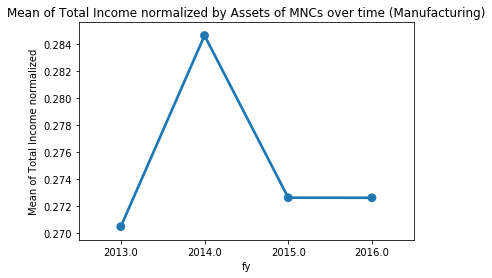

In [26]:
# Total Income normalized by Assets of MNCs over time
sns.pointplot(x=total_income_industry2_mean_scaled[total_income_industry2_mean_scaled['Type of Firm']=='Foreign'].fy,
         y=total_income_industry2_mean_scaled[total_income_industry2_mean_scaled['Type of Firm']=='Foreign'].Total_Income_scaled)

plt.title('Mean of Total Income normalized by Assets of MNCs over time (Manufacturing)')
plt.ylabel('Mean of Total Income normalized')

Text(0,0.5,'Mean of Total Income normalized')

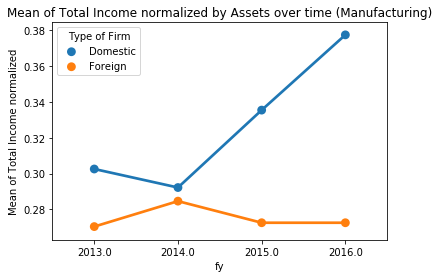

In [27]:
# Total Income normalized by Assets over time
sns.pointplot(x='fy', y='Total_Income_scaled', hue='Type of Firm', data=total_income_industry2_mean_scaled)

plt.title('Mean of Total Income normalized by Assets over time (Manufacturing)')
plt.ylabel('Mean of Total Income normalized')

**R&D**

In [28]:
# Mean of (R & D / Assets) of firms in industry 2 per year
r_and_d_industry2_mean_scaled =\
pd.DataFrame(industry2[industry2['ResearchAndDevelopmentExpense_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','ResearchAndDevelopmentExpense_scaled']].\
             groupby(['fy','Type of Firm'])['ResearchAndDevelopmentExpense_scaled'].mean()).reset_index()

Text(0,0.5,'Mean of R&D Expense normalized')

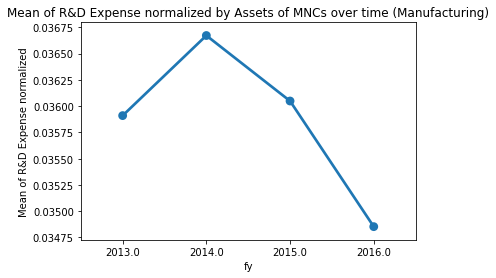

In [29]:
# R & D normalized by Assets of MNCs over time
sns.pointplot(x=r_and_d_industry2_mean_scaled[r_and_d_industry2_mean_scaled['Type of Firm']=='Foreign'].fy,
         y=r_and_d_industry2_mean_scaled[r_and_d_industry2_mean_scaled['Type of Firm']=='Foreign'].ResearchAndDevelopmentExpense_scaled)

plt.title('Mean of R&D Expense normalized by Assets of MNCs over time (Manufacturing)')
plt.ylabel('Mean of R&D Expense normalized')

Text(0,0.5,'Mean of R&D Expense normalized')

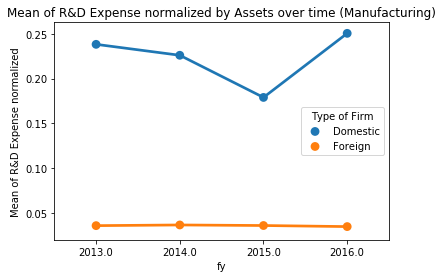

In [30]:
# R & D normalized by Assets over time
sns.pointplot(x='fy', y='ResearchAndDevelopmentExpense_scaled',hue='Type of Firm', data=r_and_d_industry2_mean_scaled)

plt.title('Mean of R&D Expense normalized by Assets over time (Manufacturing)')
plt.ylabel('Mean of R&D Expense normalized')

**Liabilities**

In [31]:
# Mean of (Liabilities/ Assets) of firms in Manufacturing per year
liabilities_industry2_mean_scaled =\
pd.DataFrame(industry2[industry2['Liabilities_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities_scaled']].\
             groupby(['fy','Type of Firm'])['Liabilities_scaled'].mean()).reset_index()

Text(0,0.5,'Mean of Liabilities normalized')

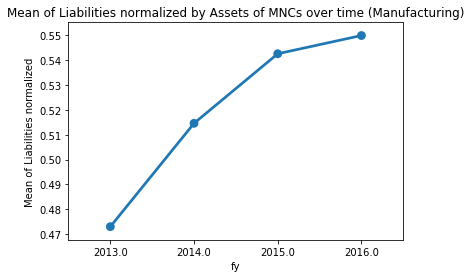

In [32]:
# Liabilities normalized by Assets of MNCs over time
sns.pointplot(x=liabilities_industry2_mean_scaled[liabilities_industry2_mean_scaled['Type of Firm']=='Foreign'].fy,
y=liabilities_industry2_mean_scaled[liabilities_industry2_mean_scaled['Type of Firm']=='Foreign'].Liabilities_scaled)

plt.title('Mean of Liabilities normalized by Assets of MNCs over time (Manufacturing)')
plt.ylabel('Mean of Liabilities normalized')

Text(0,0.5,'Mean of Liabilities normalized')

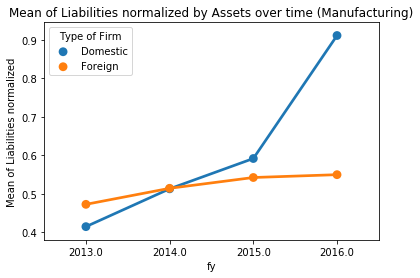

In [33]:
# Liabilities normalized by Assets  over time
sns.pointplot(x='fy', y= 'Liabilities_scaled', hue='Type of Firm', data=liabilities_industry2_mean_scaled)

plt.title('Mean of Liabilities normalized by Assets over time (Manufacturing)')
plt.ylabel('Mean of Liabilities normalized')

#### Foreign Income

In [34]:
manu_mnc = industry2.copy()[industry2.copy()['Type of Firm']=='Foreign']

In [35]:
manu_mnc['Foreign_Income_scaled'] = manu_mnc['IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign'] / manu_mnc['Assets']

Text(0,0.5,'Foreign Income of MCNs')

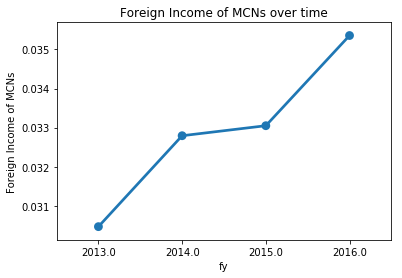

In [36]:
sns.pointplot(x='fy',
              y='Foreign_Income_scaled',
             data=manu_mnc[manu_mnc.Foreign_Income_scaled.notnull()].groupby('fy').Foreign_Income_scaled.mean().reset_index())

plt.title('Foreign Income of MCNs over time')
plt.ylabel('Foreign Income of MCNs')

In [42]:
df.head(10)

,Assets,adsh,cik,coreg,ddate,ein,fy,fye,period,sic,...,IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign,IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments,ForeignEarningsRepatriated,IncomeLossFromContinuingOperationsBeforeIncomeTaxesDomestic,ResearchAndDevelopmentExpense,Liabilities,NetIncomeLoss,GrossProfit,ProfitLoss,Type of Firm
0,1.703727e+09,0001047469-11-006302,1750,NaN,20110531.0,362334820.0,2011.0,531.0,20110531.0,3720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,69826000.0,NaN,NaN,Domestic
1,2.195700e+09,0001104659-12-065381,1750,NaN,20120531.0,362334820.0,2012.0,531.0,20120531.0,3720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic
2,2.136900e+09,0001104659-13-072128,1750,NaN,20130531.0,362334820.0,2013.0,531.0,20130531.0,3720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic
3,2.199500e+09,0001104659-14-067921,1750,NaN,20140531.0,362334820.0,2014.0,531.0,20140531.0,3720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domestic
4,1.515000e+09,0001047469-15-006136,1750,NaN,20150531.0,362334820.0,2015.0,531.0,20150531.0,3720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10200000.0,1.593000e+08,1.040000e+07,Domestic
5,1.442100e+09,0001047469-16-014299,1750,NaN,20160531.0,362334820.0,2016.0,531.0,20160531.0,3720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,47700000.0,2.369000e+08,4.770000e+07,Domestic
6,1.504100e+09,0001047469-17-004528,1750,NaN,20170531.0,362334820.0,2017.0,531.0,20170531.0,3720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,56500000.0,2.765000e+08,5.650000e+07,Domestic
7,5.241662e+10,0001047469-10-001018,1800,NaN,20091231.0,360698440.0,2009.0,1231.0,20091231.0,2834.0,...,NaN,NaN,NaN,NaN,NaN,5.694000e+09,NaN,NaN,5.745838e+09,Domestic
8,5.946227e+10,0001047469-11-001056,1800,NaN,20101231.0,360698440.0,2010.0,1231.0,20101231.0,2834.0,...,5.692000e+09,NaN,NaN,-275000000.0,NaN,NaN,NaN,5.922800e+09,4.626172e+09,Foreign
9,6.027689e+10,0001047469-12-001216,1800,NaN,20111231.0,360698440.0,2011.0,1231.0,20111231.0,2834.0,...,4.835000e+09,NaN,NaN,364000000.0,NaN,NaN,NaN,6.539600e+09,NaN,Foreign
